# Direct Arylation

## Bayesian Optimization Results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

from sklearn.model_selection import train_test_split

import sys_path
from Data import suzuki, aryl_amination, direct_arylation, Data
from plot_utils import prior_plot, plot_avg_convergence, compare_convergence, average_convergence
from bro import BO

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

from gpytorch.priors import NormalPrior, SmoothedBoxPrior

RDKit WARNING: [11:45:07] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
dft = Data(direct_arylation(base='dft', ligand='boltzmann-dft', solvent='dft'))
dft.data.head()

entry base_file_name      base_SMILES base_stoichiometry  \
0      0           KOAc  O=C([O-])C.[K+]            C2H3KO2   
1      1           KOAc  O=C([O-])C.[K+]            C2H3KO2   
2      2           KOAc  O=C([O-])C.[K+]            C2H3KO2   
3      3           KOAc  O=C([O-])C.[K+]            C2H3KO2   
4      4           KOAc  O=C([O-])C.[K+]            C2H3KO2   

   base_number_of_atoms  base_charge  base_multiplicity  \
0                     8            0                  1   
1                     8            0                  1   
2                     8            0                  1   
3                     8            0                  1   
4                     8            0                  1   

  base_convergence_criteria  base_dipole  base_molar_mass  base_molar_volume  \
0                       met       7.1686          98.1428            545.524   
1                       met       7.1686          98.1428            545.524   
2                       met       7.1686          98.1428            545.524   
3                       met       7.1686          98.1428            545.524   
4                       met       7.1686          98.1428            545.524   

   base_electronic_spatial_extent  base_homo_energy  base_lumo_energy  \
0                        641.7535          -0.19743          -0.04683   
1                        641.7535          -0.19743          -0.04683   
2                        641.7535          -0.19743          -0.04683   
3                        641.7535          -0.19743          -0.04683   
4                        641.7535          -0.19743          -0.04683   

   base_electronegativity  base_hardness  base_electrophilicity  base_E_scf  \
0                 0.12213         0.0753                 0.0753  -828.44532   
1                 0.12213         0.0753                 0.0753  -828.44532   
2                 0.12213         0.0753                 0.0753  -828.44532   
3                 0.12213         0.0753                 0.0753  -828.44532   
4                 0.12213         0.0753                 0.0753  -828.44532   

   base_zero_point_correction  base_E_thermal_correction  \
0                    0.050381                   0.056594   
1                    0.050381                   0.056594   
2                    0.050381                   0.056594   
3                    0.050381                   0.056594   
4                    0.050381                   0.056594   

   base_H_thermal_correction  base_G_thermal_correction  base_E_zpe  \
0                   0.057539                   0.018561 -828.394939   
1                   0.057539                   0.018561 -828.394939   
2                   0.057539                   0.018561 -828.394939   
3                   0.057539                   0.018561 -828.394939   
4                   0.057539                   0.018561 -828.394939   

       base_E      base_H      base_G  base_ES_root_dipole  \
0 -828.388726 -828.387782 -828.426759               8.5245   
1 -828.388726 -828.387782 -828.426759               8.5245   
2 -828.388726 -828.387782 -828.426759               8.5245   
3 -828.388726 -828.387782 -828.426759               8.5245   
4 -828.388726 -828.387782 -828.426759               8.5245   

   base_ES_root_molar_volume  base_ES_root_electronic_spatial_extent  \
0                    606.138                                685.0531   
1                    606.138                                685.0531   
2                    606.138                                685.0531   
3                    606.138                                685.0531   
4                    606.138                                685.0531   

   base_ES1_transition  base_ES1_osc_strength  base_ES1_<S**2>  \
0               363.32                 0.0031              0.0   
1               363.32                 0.0031              0.0   
2               363.32                 0.0031              0.0   
3               

In [3]:
# Remove unwanted columns
dft.clean()
dft.drop(['entry', 'vibration', 'correlation', 'Rydberg', 'correction', 
          'atom_number', 'E-M_angle', 'MEAN', 'STDEV'])
    
# Standardize
dft.standardize(scaler='minmax')
   
# Drop highly correlated features
dft.uncorrelated(threshold=0.95)

C:\Users\Ben\Dropbox\0_projects\BMS_Adams_Bayesian_Optimization\@bro\bro-sim\paper_figures\Data.py:413: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new[target] = list(df[target])


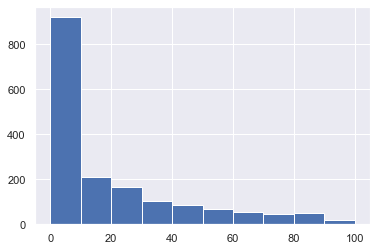

In [4]:
dft.data['yield'].hist()

In [5]:
dft.data

base_number_of_atoms  base_dipole  base_homo_energy  \
0                      0.0          0.0          0.126129   
1                      0.0          0.0          0.126129   
2                      0.0          0.0          0.126129   
3                      0.0          0.0          0.126129   
4                      0.0          0.0          0.126129   
...                    ...          ...               ...   
1723                   1.0          1.0          0.790914   
1724                   1.0          1.0          0.790914   
1725                   1.0          1.0          0.790914   
1726                   1.0          1.0          0.790914   
1727                   1.0          1.0          0.790914   

      base_ES_root_dipole  base_ES_root_molar_volume  base_ES1_osc_strength  \
0                0.373306                   0.000000               0.538462   
1                0.373306                   0.000000               0.538462   
2                0.373306                   0.000000               0.538462   
3                0.373306                   0.000000               0.538462   
4                0.373306                   0.000000               0.538462   
...                   ...                        ...                    ...   
1723             0.954080                   0.790256               0.538462   
1724             0.954080                   0.790256               0.538462   
1725             0.954080                   0.790256               0.538462   
1726             0.954080                   0.790256               0.538462   
1727             0.954080                   0.790256               0.538462   

      base_ES3_osc_strength  base_ES4_osc_strength  base_ES6_osc_strength  \
0                       1.0                    0.0               0.163158   
1                       1.0                    0.0               0.163158   
2                       1.0                    0.0               0.163158   
3                       1.0                    0.0               0.163158   
4                       1.0                    0.0               0.163158   
...                     ...                    ...                    ...   
1723                    0.0                    1.0               0.081579   
1724                    0.0                    1.0               0.081579   
1725                    0.0                    1.0               0.081579   
1726                    0.0                    1.0               0.081579   
1727                    0.0                    1.0               0.081579   

      base_ES9_osc_strength  base_atom1_Mulliken_charge  \
0                  1.000000                    0.935668   
1                  1.000000                    0.935668   
2                  1.000000                    0.935668   
3                  1.000000                    0.935668   
4                  1.000000                    0.935668   
...                     ...                         ...   
1723               0.572727                    1.000000   
1724               0.572727                    1.000000   
1725               0.572727                    1.000000   
1726               0.572727                    1.000000   
1727               0.572727                    1.000000   

      base_atom1_NMR_anisotropy  base_atom2_Mulliken_charge  \
0                           0.0                    0.989973   
1                           0.0                    0.989973   
2                           0.0                    0.989973   
3                           0.0                    0.989973   
4                           0.0                    0.989973   
...                         ...                         ...   
1723                        1.0                    0.427428   
1724                        1.0                    0.427428   
1725                        1.0                    0.427428   
1726                        1.0                    0.427428 

In [30]:
# Simulation setup
NSIM = 50 # Same number of entries we have for the game as of 2.10.20
NBATCH = 19

In [54]:
# Random baseline

from models import Random

bo = BO(exindex=dft.data,
        domain=dft.data.drop('yield', axis=1),
        batch_size=5,
        acquisition_function='rand',
        init_method='rand',
        model=Random)

random_baseline = []
for i in range(NSIM):
    bo.simulate(iterations=NBATCH, seed=i)
    random_baseline.append(bo.obj.results_input()['yield'].values)
    bo.init_seq.visualize = False
    
#pd.DataFrame(data=random_baseline).to_csv('direct_arylation/random_baseline.csv')

0 100.0


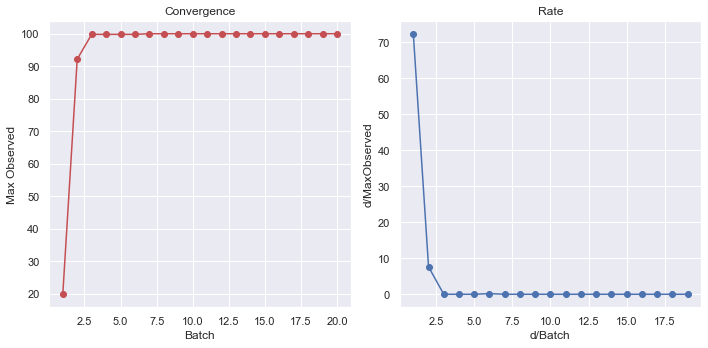

1 100.0


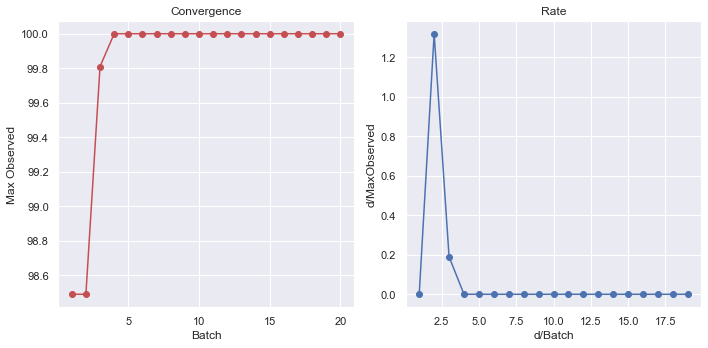

2 100.0


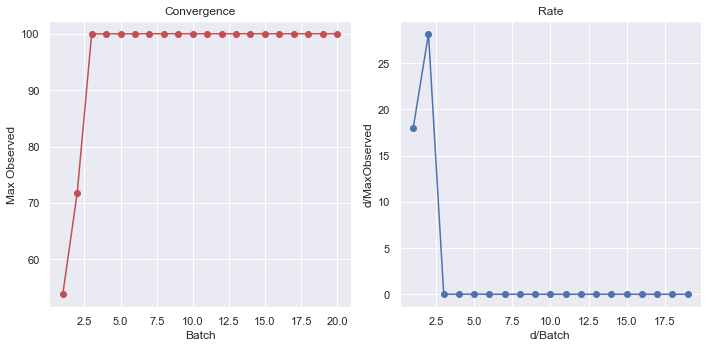

3 100.0


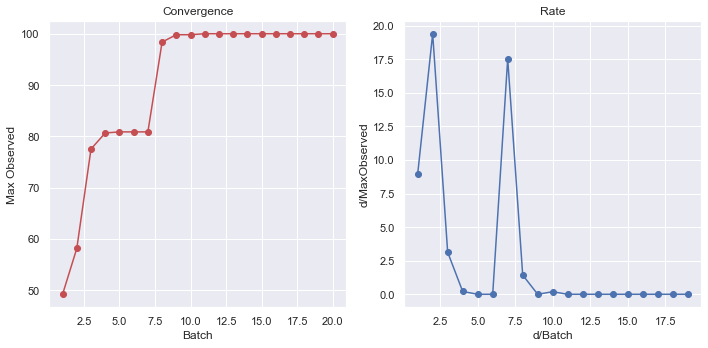

4 100.0


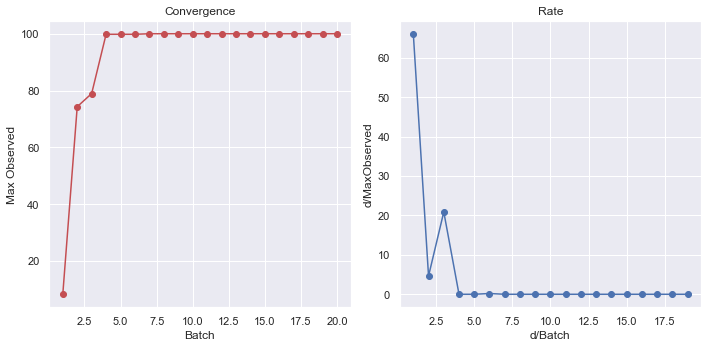

5 100.0


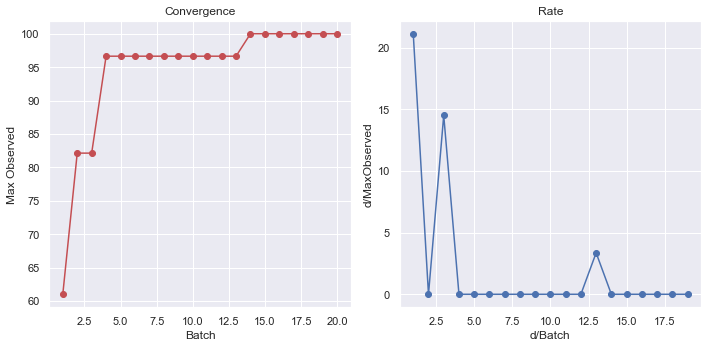

6 100.0


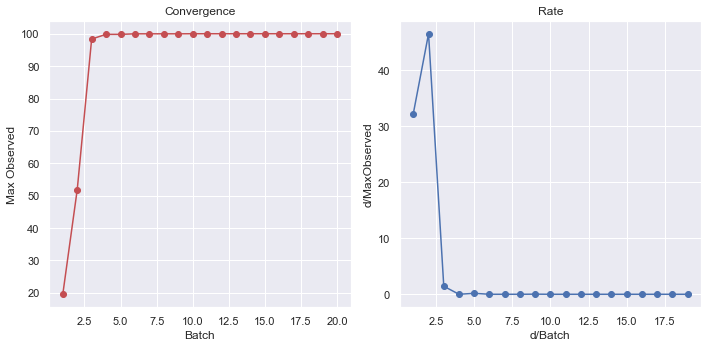

7 100.0


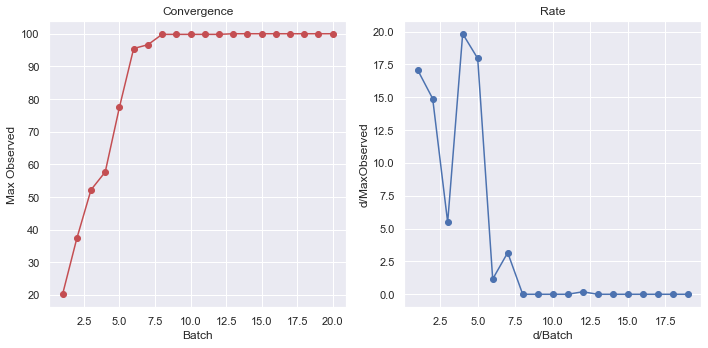

8 100.0


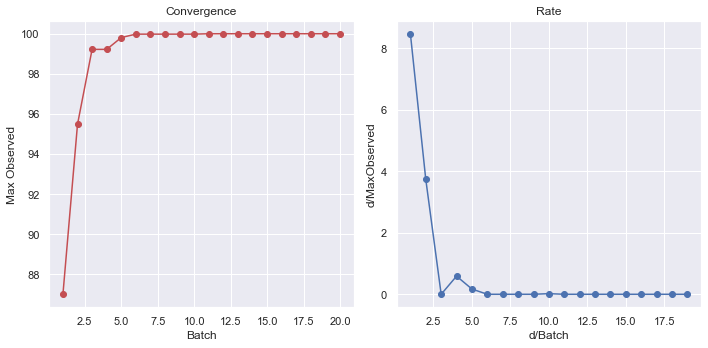

9 100.0


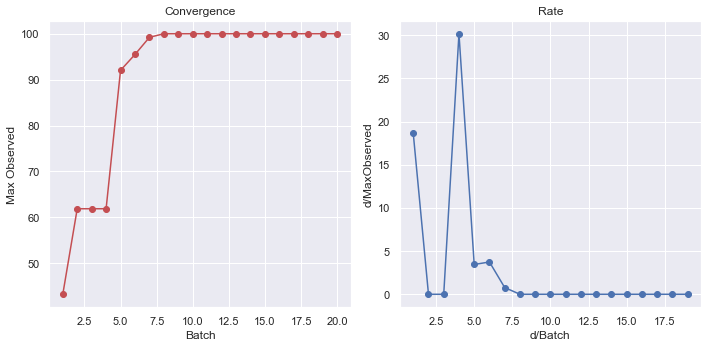

10 100.0


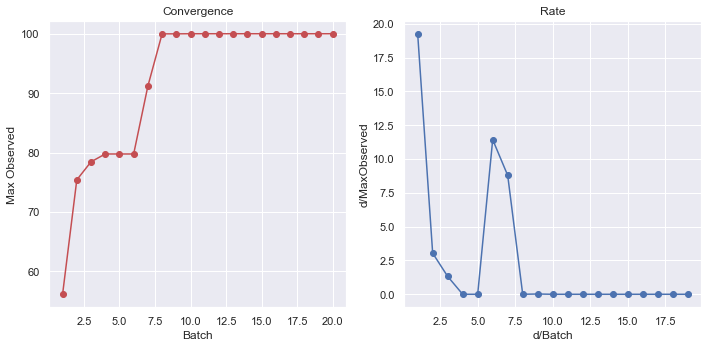

11 100.0


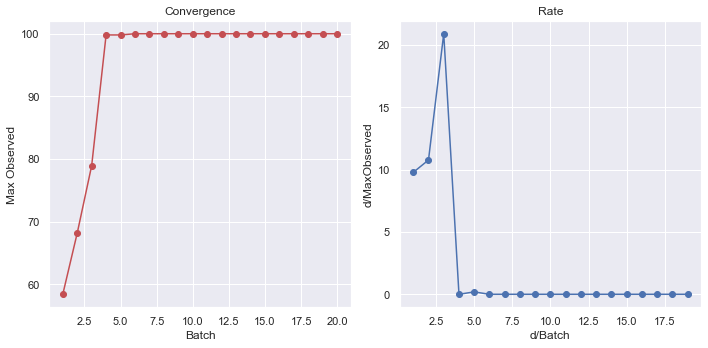

12 100.0


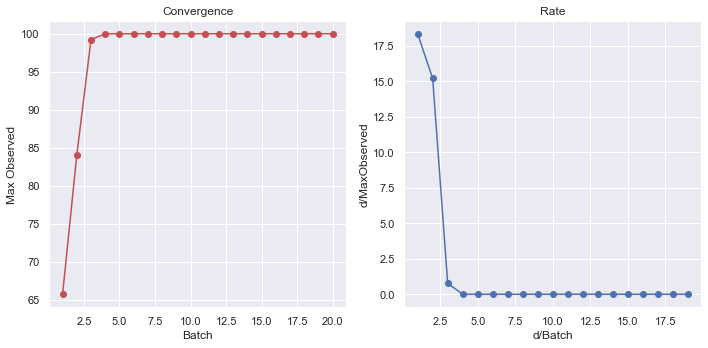

13 100.0


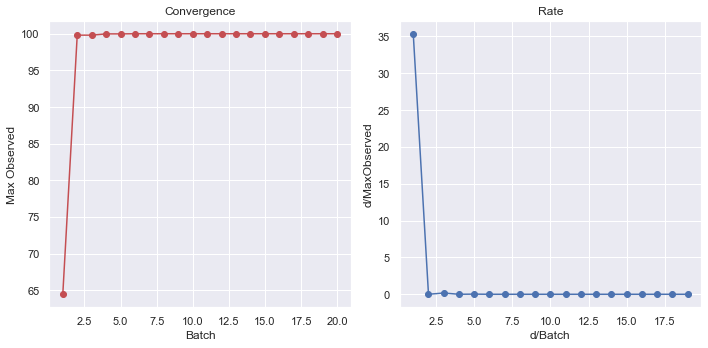

14 100.0


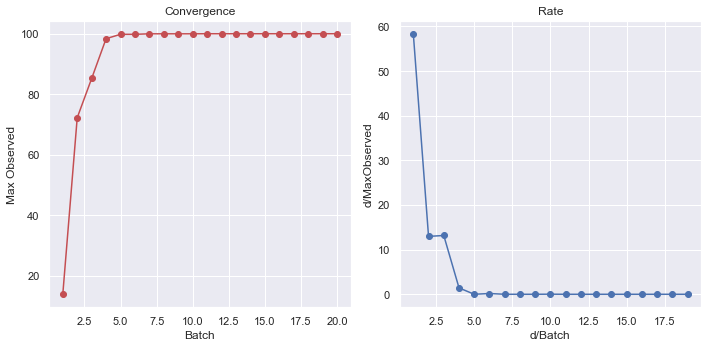

15 100.0


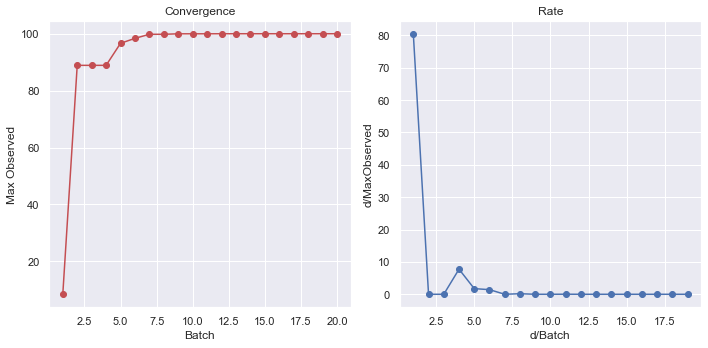

16 100.0


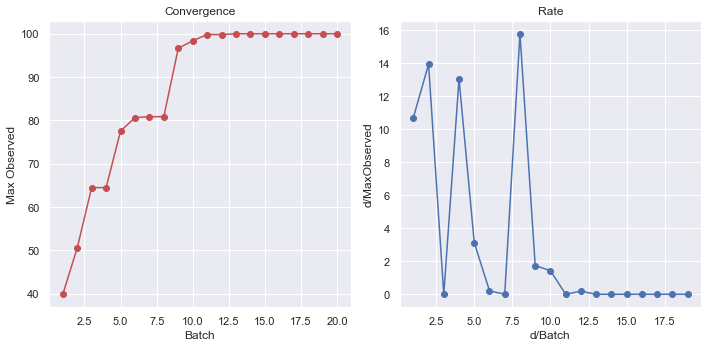

17 100.0


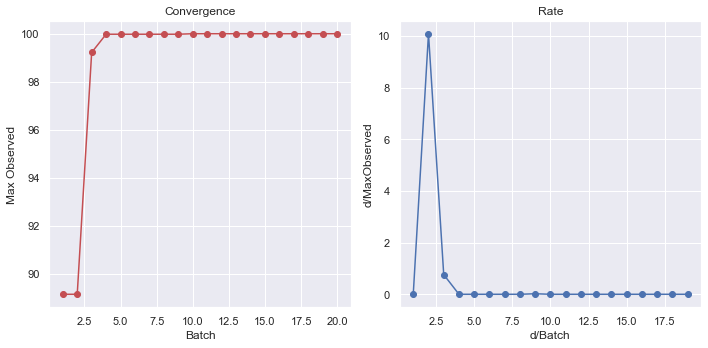

18 100.0


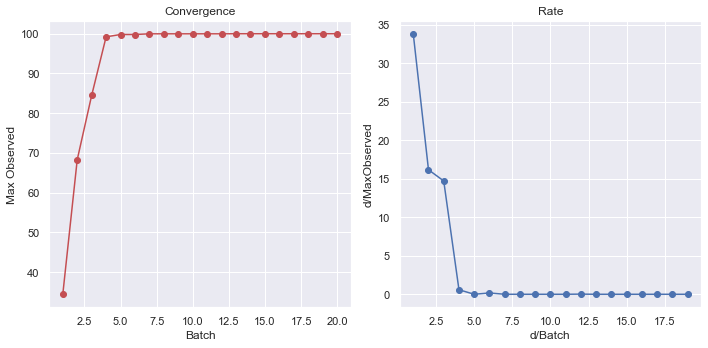

19 100.0


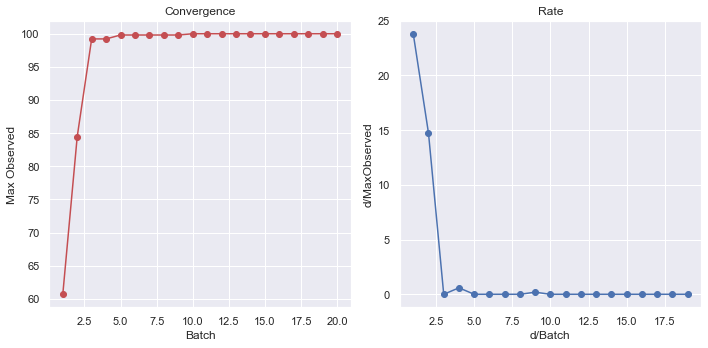

20 100.0


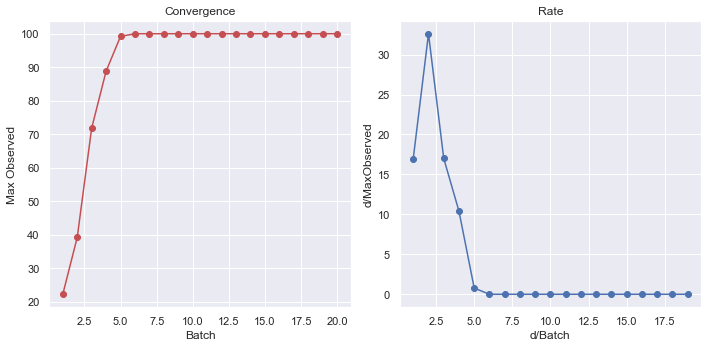

21 100.0


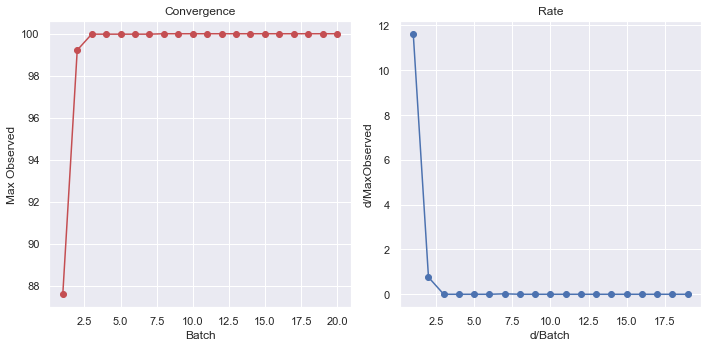

22 100.0


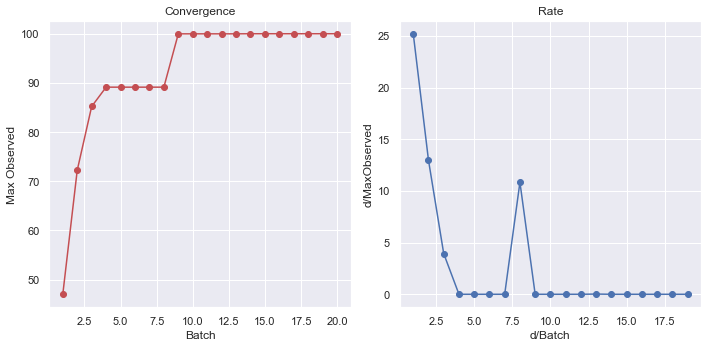

23 100.0


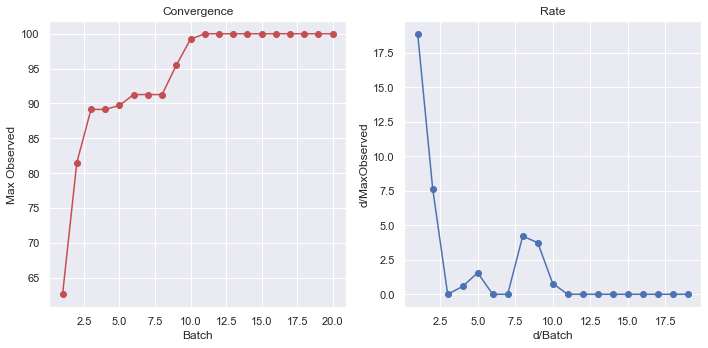

24 100.0


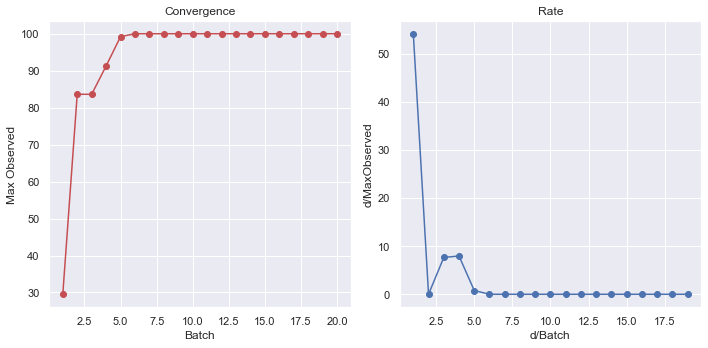

25 100.0


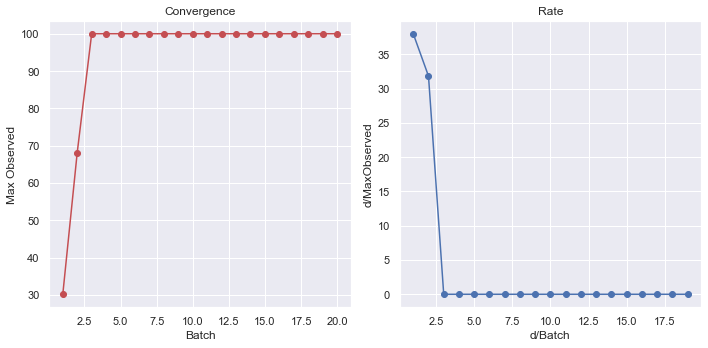

26 100.0


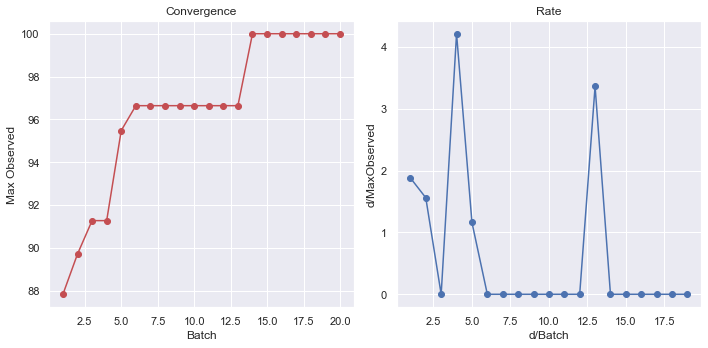

27 100.0


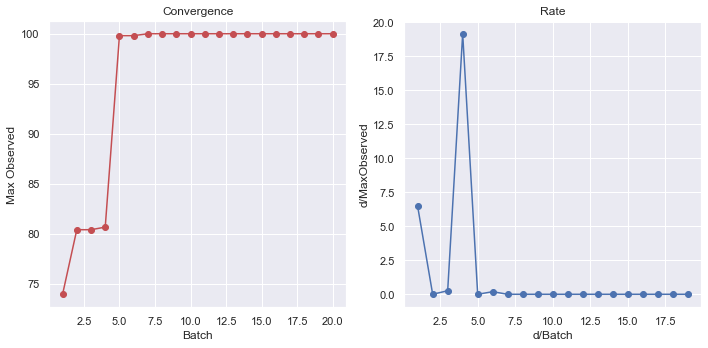

28 100.0


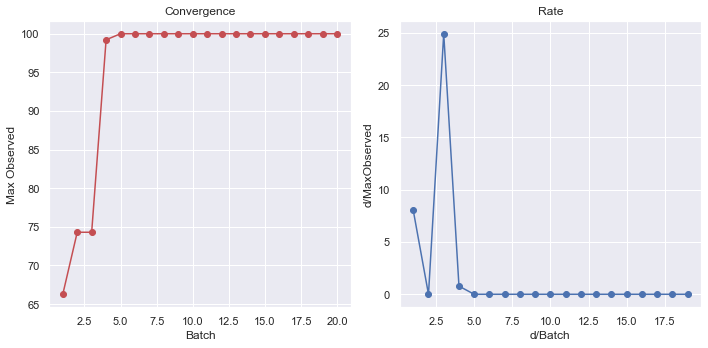

29 100.0


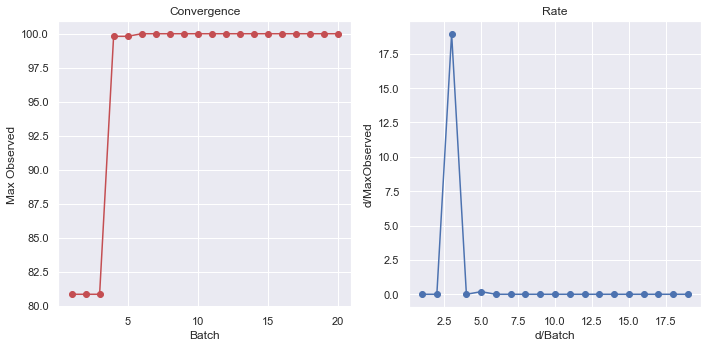

30 100.0


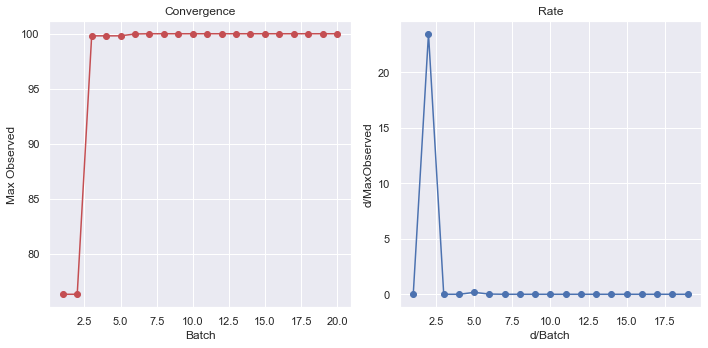

31 100.0


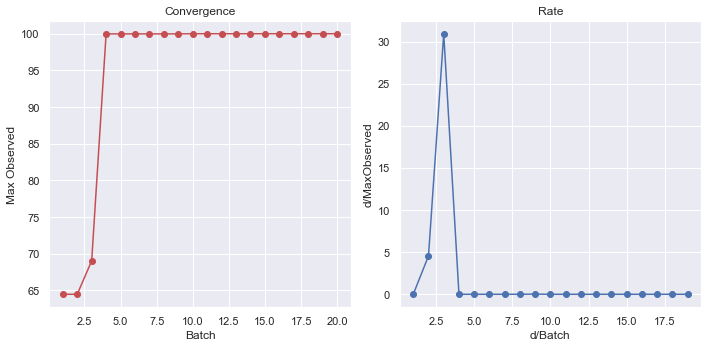

32 100.0


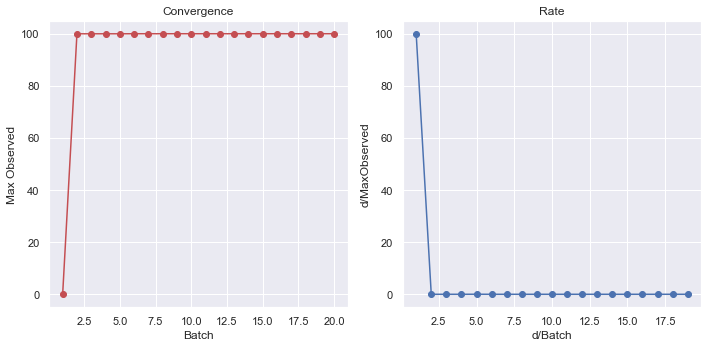

33 100.0


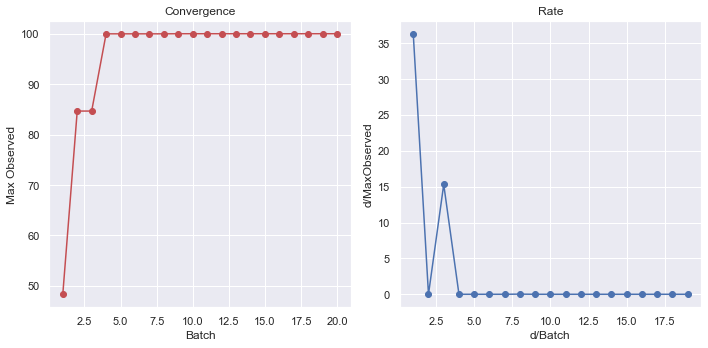

34 100.0


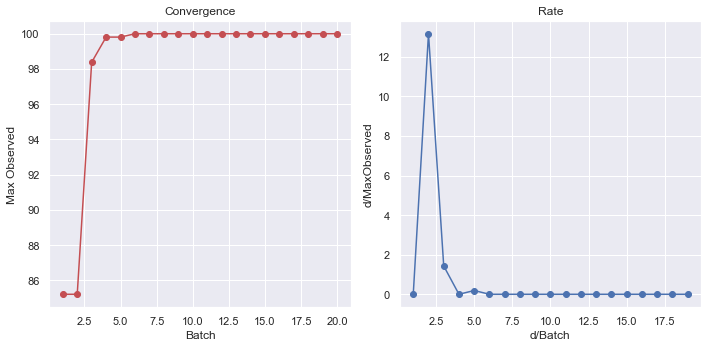

35 100.0


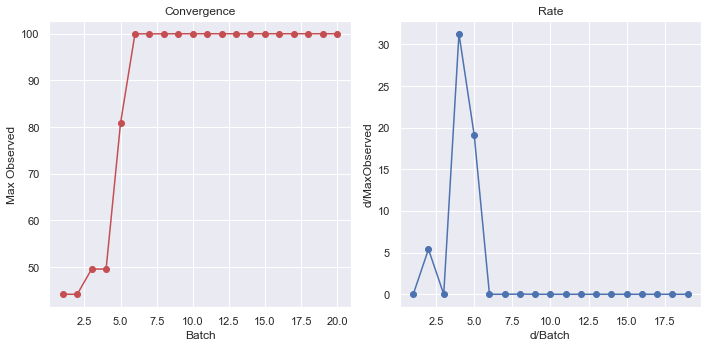

36 100.0


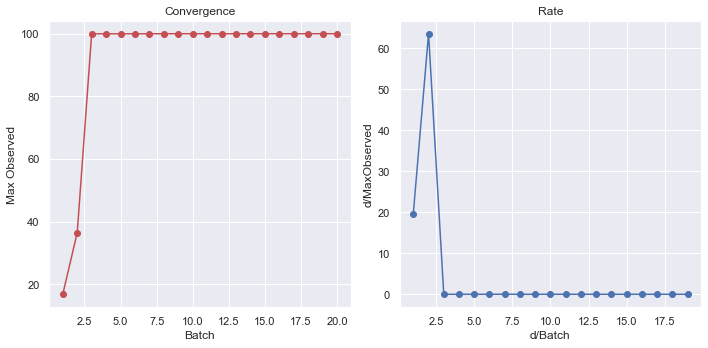

37 100.0


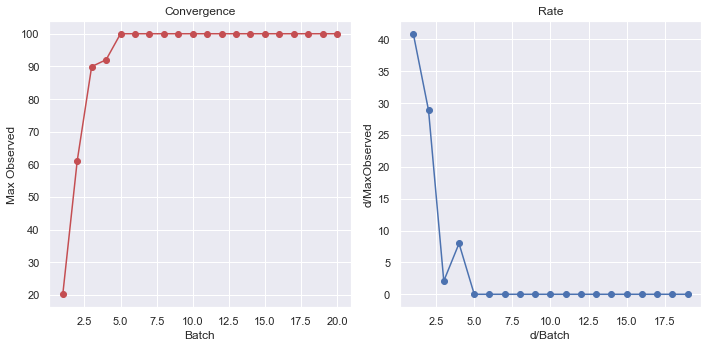

38 100.0


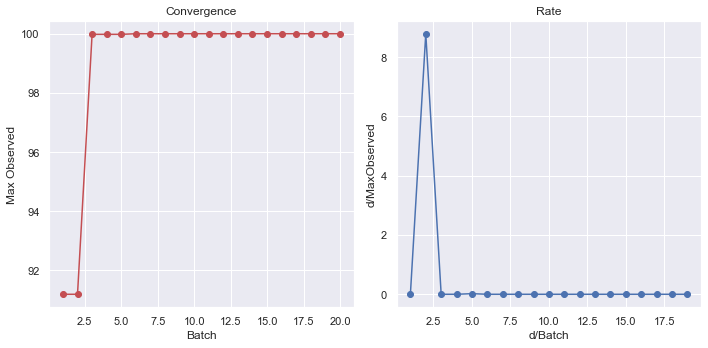

39 100.0


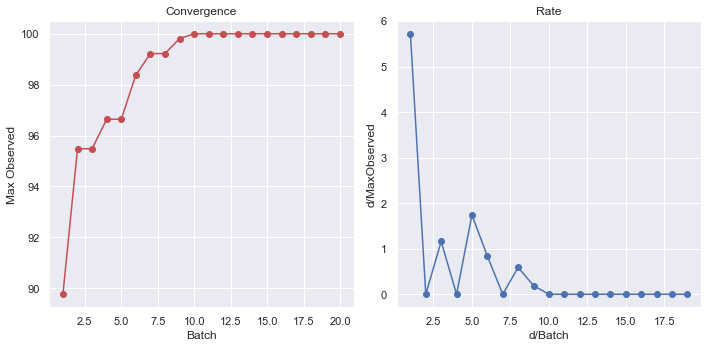

40 100.0


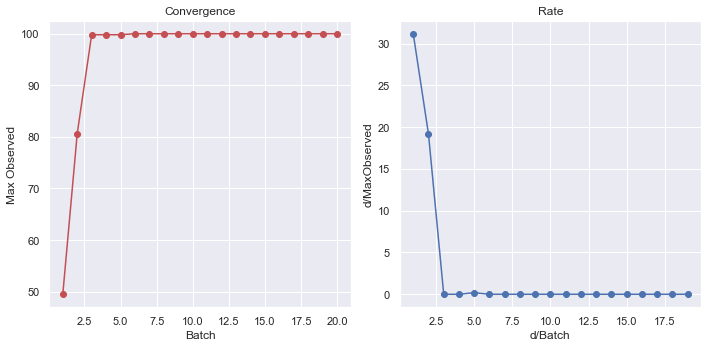

41 100.0


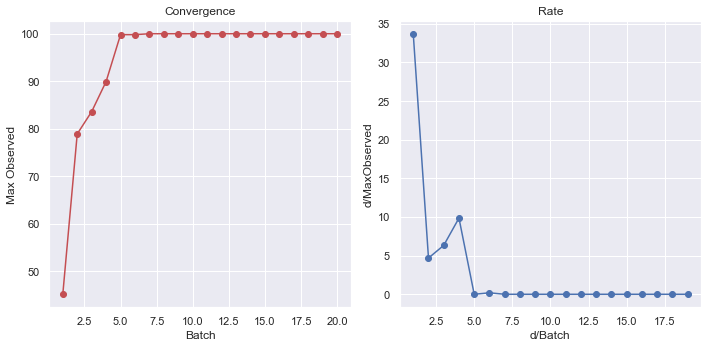

42 100.0


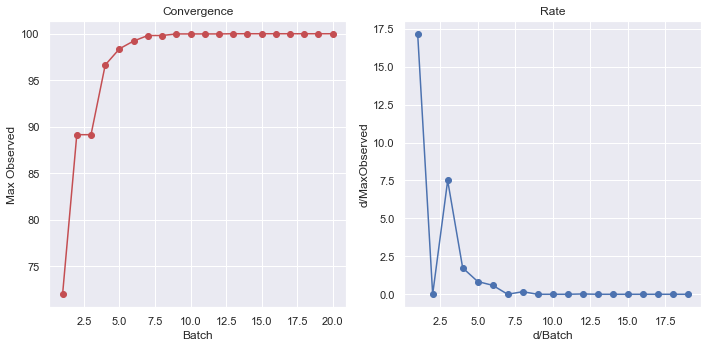

43 100.0


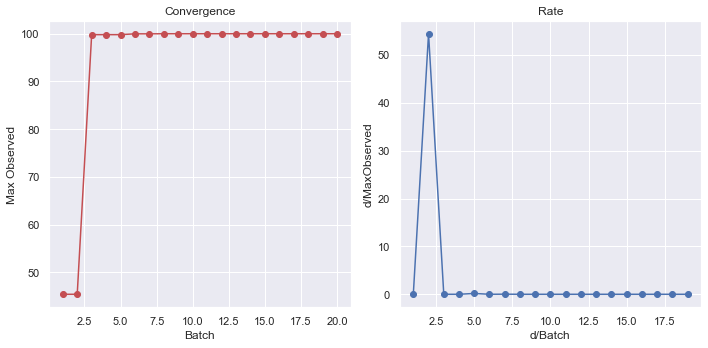

44 100.0


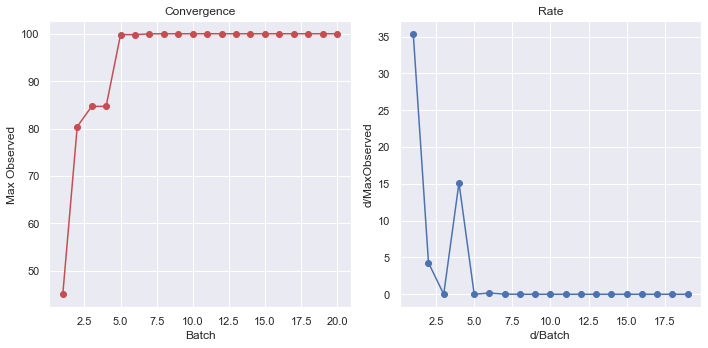

45 100.0


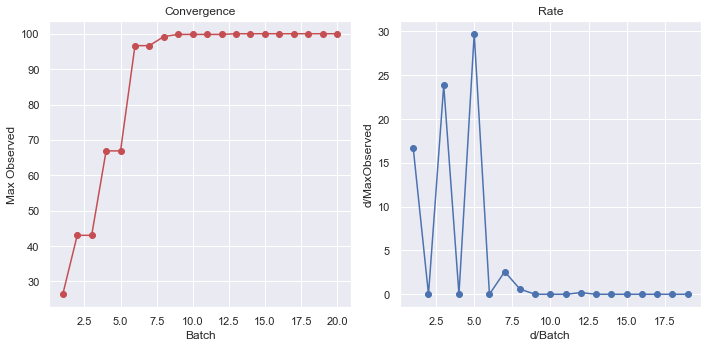

46 100.0


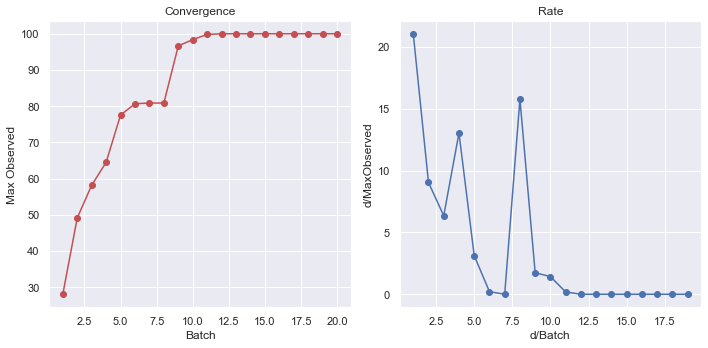

47 100.0


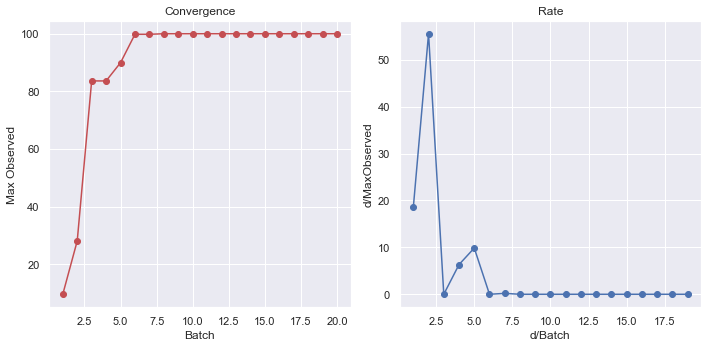

48 100.0


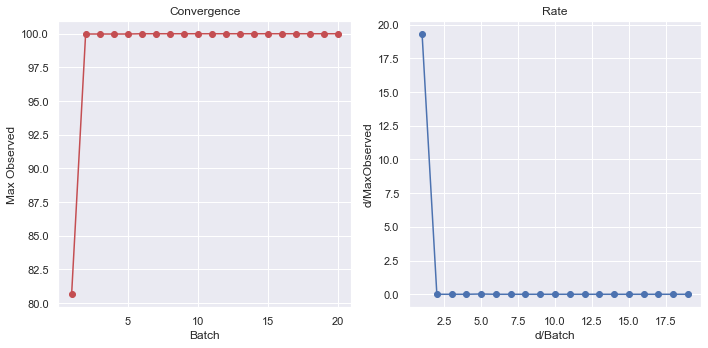

49 100.0


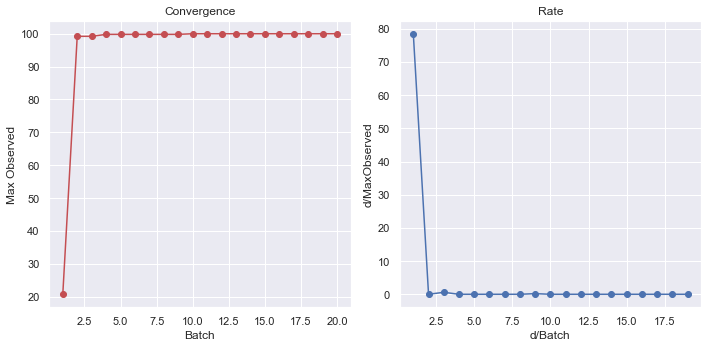

In [34]:
bo = BO(exindex=dft.data,
        domain=dft.data.drop('yield', axis=1),
        batch_size=5,
        init_method='rand',
        acquisition_function='EI')

results = []
for i in range(NSIM):
    bo.simulate(iterations=NBATCH, seed=i)
    results.append(bo.obj.results_input()['yield'].values)
    print(i, max(results[i]))
    bo.plot_convergence()
    
#pd.DataFrame(data=results).to_csv('direct_arylation/results.csv')

## Game Results

In [6]:
data = pd.read_excel('game_summary_table.xlsx')
data

file_name collected_from  \
0         Alina_Pharma_Process Chemist_1_5 years.csv            BMS   
1                 BenC_Pharma_Engineer_1_5 years.csv            BMS   
2   Chris Bemis_Pharma_Process Chemist_1_5 years.csv            BMS   
3         ChrisWilbert_Pharma_Engineer_1_5 years.csv            BMS   
4           CSH_Pharma_Process Chemist_1_5 years.csv            BMS   
..                                               ...            ...   
45           sigmanck_Academic_Postdoc_1~5 years.csv     Sigman_lab   
46  SigmanCS_Academic_Graduate Student_1~5 years.csv     Sigman_lab   
47           SigmanTG_Academic_Postdoc_1~5 years.csv     Sigman_lab   
48            trial_Pharma_Med Chemist_1_5 years.csv            BMS   
49          Yuxuan Ye_Academic_Postdoc_1~5 years.csv     Hyster_lab   

        nickname      area         expertise experience  yield_1  temp_1  \
0          Alina    Pharma   Process Chemist  1_5 years     5.47     105   
1           BenC    Pharma          Engineer  1_5 years     2.41     105   
2    Chris Bemis    Pharma   Process Chemist  1_5 years     5.47     105   
3   ChrisWilbert    Pharma          Engineer  1_5 years     0.00     105   
4            CSH    Pharma   Process Chemist  1_5 years     5.47     105   
..           ...       ...               ...        ...      ...     ...   
45            CK  Academic           Postdoc  1_5 years     1.71      90   
46            CS  Academic  Graduate Student  1_5 years     0.00     105   
47            TG  Academic           Postdoc  1_5 years    29.16     105   
48         trial    Pharma       Med Chemist  1_5 years    28.64     105   
49     Yuxuan Ye  Academic           Postdoc  1_5 years    27.48     105   

    conc_1 solvent_1    ligand_1  base_1  yield_2  temp_2  conc_2 solvent_2  \
0    0.100      DMAc   BrettPhos    KOAc     0.07     105   0.100      DMAc   
1    0.057      DMAc   BrettPhos    KOAc     0.12     105   0.057      DMAc   
2    0.100      DMAc   BrettPhos    KOAc    75.22     105   0.100      DMAc   
3    0.100      DMAc     PPhtBu2    KOAc     7.26     105   0.100      DMAc   
4    0.100      DMAc   BrettPhos    KOAc    65.37     105   0.100      DMAc   
..     ...       ...         ...     ...      ...     ...     ...       ...   
45   0.100      DMAc   PCy3 HBF4    KOAc     6.78     105   0.057      BuCN   
46   0.100      DMAc   BrettPhos  CsOPiv     0.00     105   0.100      DMAc   
47   0.100      DMAc      X-Phos  CsOPiv    65.37     105   0.100      DMAc   
48   0.100      DMAc  tBPh-CPhos   KOPiv     7.62     105   0.100      DMAc   
49   0.100     BuOAc   BrettPhos  CsOPiv    59.92     105   0.100     BuOAc   

      ligand_2  base_2  yield_3  temp_3  conc_3 solvent_3         ligand_3  \
0    BrettPhos   KOPiv     4.74     105   0.100      DMAc        BrettPhos   
1      PPhtBu2    KOAc     0.00     105   0.057      BuCN          PPhtBu2   
2   JackiePhos    KOAc    41.90     105   0.100      DMAc          P(fur)3   
3    PCy3 HBF4    KOAc    80.38     105   0.100      DMAc         CgMe-PPh   
4       X-Phos    KOAc    13.11     105   0.100      DMAc  GorlosPhos HBF4   
..         ...     ...      ...     ...     ...       ...              ...   
45        PPh3   KOPiv     6.23     120   0.153     BuOAc           X-Phos   
46  JackiePhos  CsOPiv    29.16     105   0.100      DMAc           X-Phos   
47      X-Phos    KOAc    53.63     105   0.100  p-Xylene           X-Phos   
48  tBPh-CPhos  CsOPiv    45.17     120   0.100      DMAc  GorlosPhos HBF4   
49      X-Phos  CsOPiv     2.41     105   0.100     BuOAc       JackiePhos   

    base_3  yield_4  temp_4  conc_4 solvent_4    ligand_4  base_4  yield_5  \
0    CsOAc    17.09     105   0.100     BuOAc   BrettPhos    KOAc    18.44   
1     KOAc    39.86     105   0.057      BuCN   BrettPhos  CsOPiv     0.26   
2     KOAc     8.23     105   0.100      DMAc      PPh2Me    KOAc    28.15   
3     KOAc    75.22     105   0.100      DMAc  JackiePhos    KOAc    28.15   
4

In [7]:
# Get yield data
yield_columns = []
for column in data.columns.values:
    if 'yield' in column:
        yield_columns.append(column)
        
yields = data[yield_columns]

In [8]:
# Get max paths without zero padding
max_paths = []
for i in range(len(yields)):
    path = yields.iloc[i].dropna().values
    max_path = []
    for j in range(1, int(len(path)/5 + 1)):
        max_path.append(path[:j*5].max())
    max_paths.append(max_path)

In [9]:
# Get max paths with zero padding
max_paths_padded = []
for i in range(len(yields)):
    path = yields.iloc[i].dropna().values
    max_path = []
    for j in range(1, int(len(path)/5 + 1)):
        max_path.append(path[:j*5].max())
    max_path = max_path + [max(max_path) for missing in range(20 - len(max_path))]
    max_paths_padded.append(max_path)

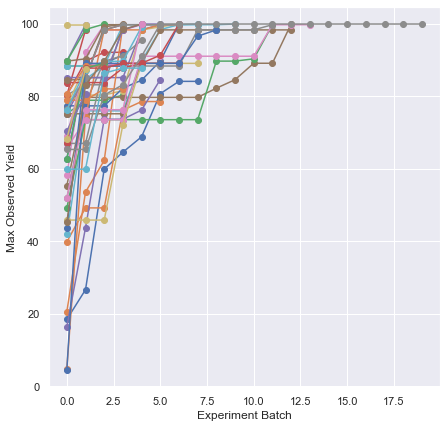

In [10]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (7, 7)

for i in range(len(max_paths)):
    plt.plot(range(len(max_paths[i])), max_paths[i], '-o', label=data['nickname'].values[i])
    
plt.xlabel('Experiment Batch')
plt.ylabel('Max Observed Yield')
#plt.legend(loc='lower right', shadow=True)


plt.savefig('human-raw_paths.svg', format='svg', dpi=1200, bbox_inches='tight')

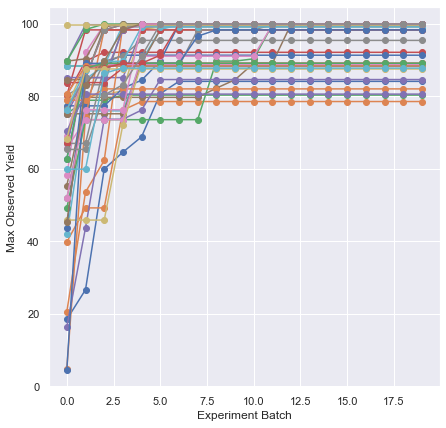

In [23]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (7, 7)

for i in range(len(max_paths_padded)):
    plt.plot(range(len(max_paths_padded[i])), max_paths_padded[i], '-o', label=data['nickname'].values[i])
    
plt.xlabel('Experiment Batch')
plt.ylabel('Max Observed Yield')
#plt.legend(loc='lower right', shadow=True)
plt.show()

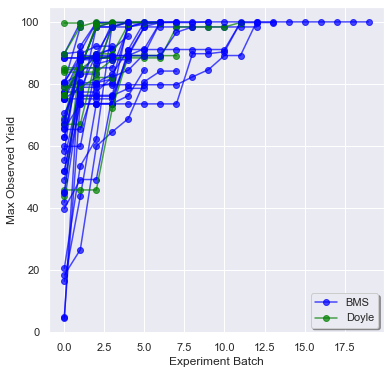

In [12]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (6, 6)

bms = 0;
doyle = 0;
for i in range(len(max_paths)):
    if data['collected_from'].values[i] == 'BMS': 
        color = 'blue'
        if bms == 0:
            label = 'BMS'
            bms = bms + 1
        else:
            label = None
    elif data['collected_from'].values[i] == 'Doyle_lab': 
        color = 'green'
        if doyle == 0:
            label = 'Doyle'
            doyle = doyle + 1
        else:
            label = None
    plt.plot(range(len(max_paths[i])), max_paths[i], '-o', alpha=0.7, color=color, label=label)
    
plt.xlabel('Experiment Batch')
plt.ylabel('Max Observed Yield')
plt.legend(loc='lower right', shadow=True)
plt.show()

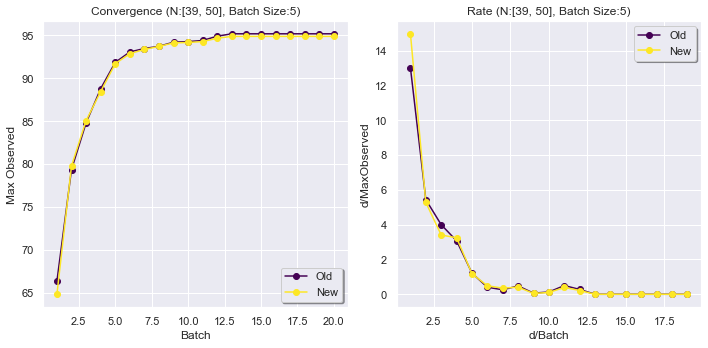

In [24]:
# All data
compare_convergence([data_init.fillna(value=0)[yield_columns].iloc[:,:100].values, data.fillna(value=0)[yield_columns].iloc[:,:100].values], 
                    5,
                    ['Old', 'New'])

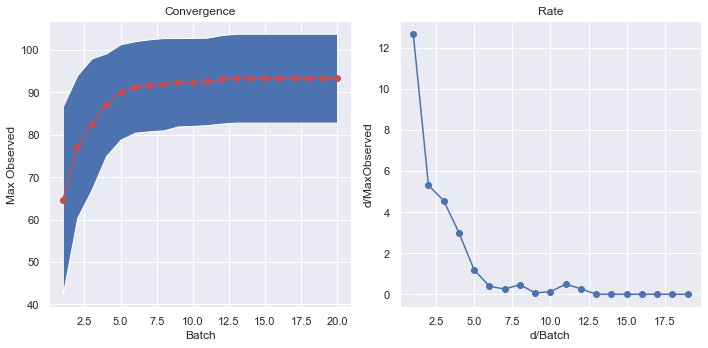

In [98]:
# All data
plot_avg_convergence(data.fillna(value=0)[yield_columns].iloc[:,:100].values, 5)

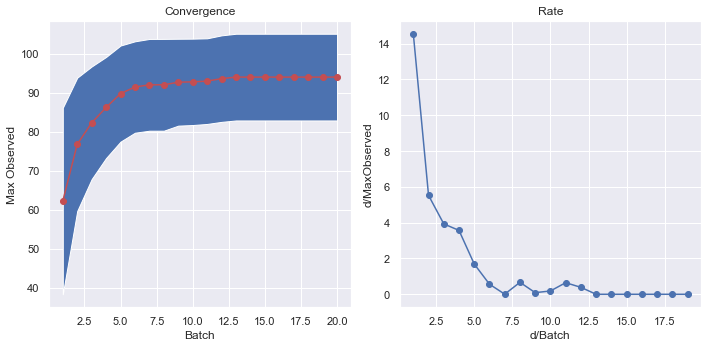

In [99]:
# BMS
subset1 = data[data['collected_from'] == 'BMS']
plot_avg_convergence(subset1.fillna(value=0)[yield_columns].iloc[:,:100].values, 5)

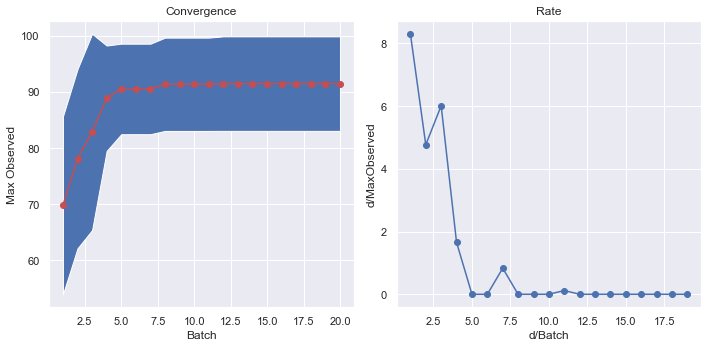

In [100]:
# Doyle
subset2 = data[data['collected_from'] == 'Doyle_lab']
plot_avg_convergence(subset2.fillna(value=0)[yield_columns].iloc[:,:100].values, 5)

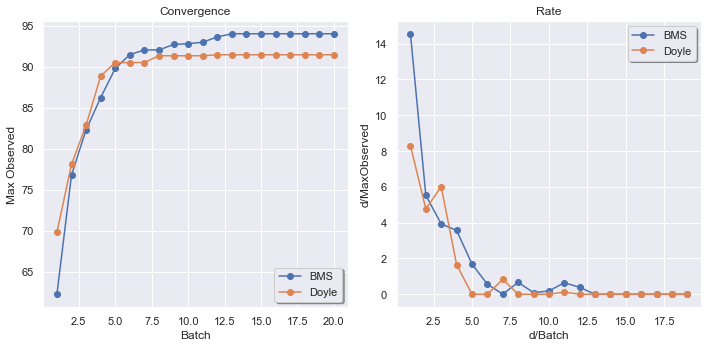

In [101]:
subsets = [subset1.fillna(value=0)[yield_columns].iloc[:,:100].values, 
           subset2.fillna(value=0)[yield_columns].iloc[:,:100].values
          ]

compare_convergence(subsets, 5, ['BMS', 'Doyle'], export_path='BMS_vs_Doyle')

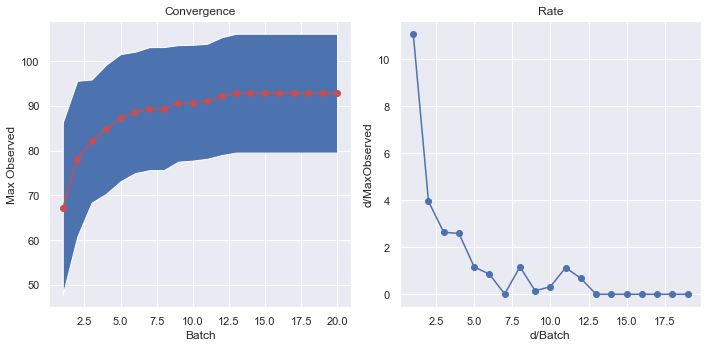

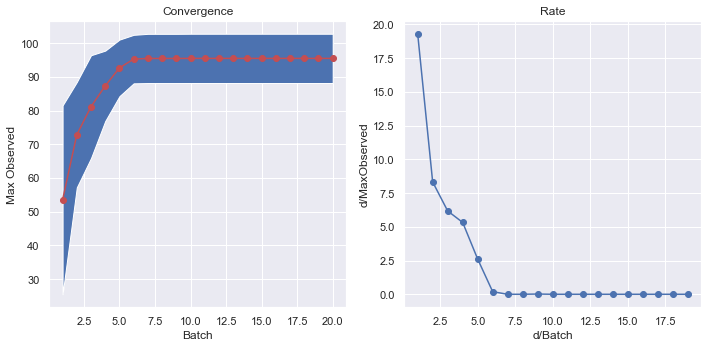

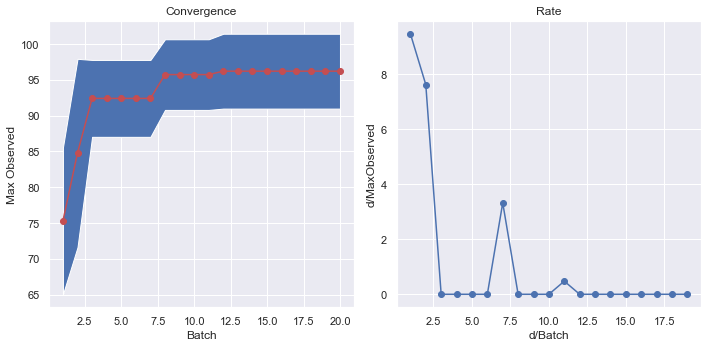

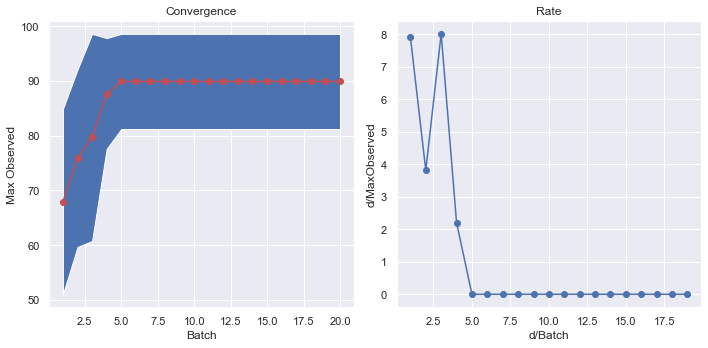

In [102]:
# Expertise
expertise = ['Process Chemist', 'Engineer', 'Postdoc', 'Graduate Student']
subsets = [data[data['expertise'] == cat] for cat in expertise]
for subset in subsets:
    plot_avg_convergence(subset.fillna(value=0)[yield_columns].iloc[:,:100].values, 5)

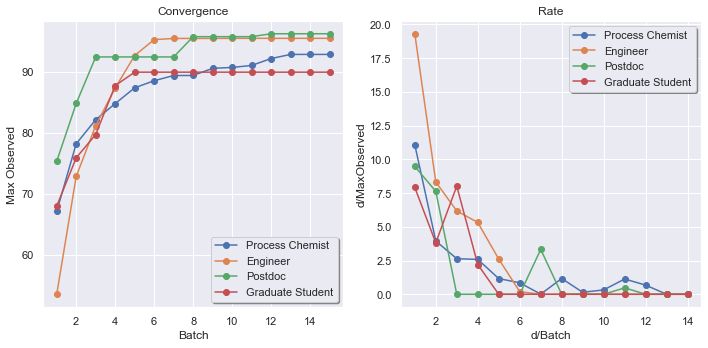

In [103]:
subsets_plot = [subset.fillna(value=0)[yield_columns].iloc[:,:75].values for subset in subsets]

compare_convergence(subsets_plot, 5, expertise, export_path='expertise')

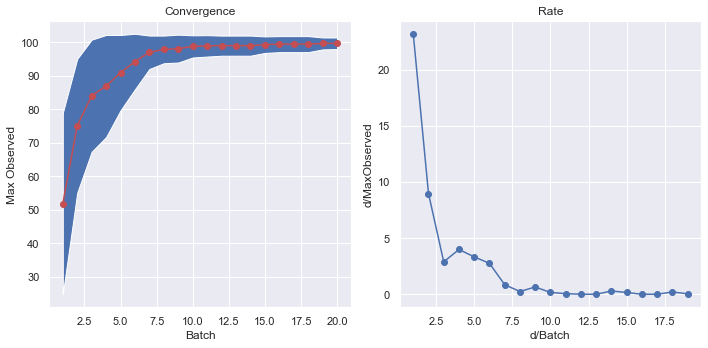

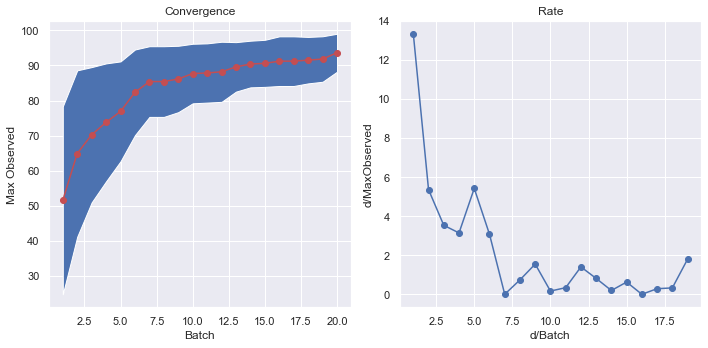

In [10]:
results = pd.read_csv('direct_arylation/results021020.csv')
random = pd.read_csv('direct_arylation/random_baseline021020.csv')

plot_avg_convergence(results.values, 5, export_path='bro_stdev')
plot_avg_convergence(random.values, 5, export_path='random_stdev')

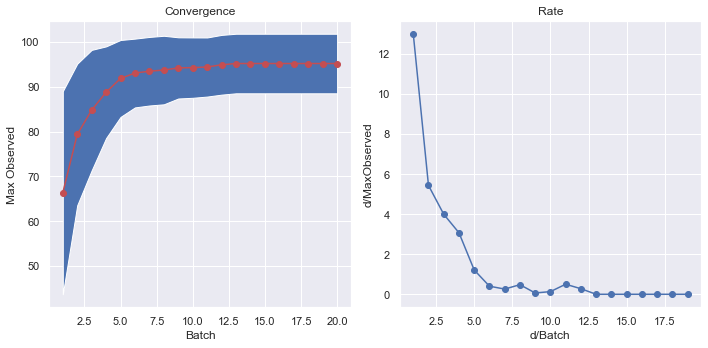

In [9]:
plot_avg_convergence(data.fillna(value=0)[yield_columns].iloc[:,:100].values, 5, export_path='chemists_stdev')

# Comparision

In [2]:
results = pd.read_csv('direct_arylation/results3.30.20.csv', index_col=0)
random_baseline = pd.read_csv('direct_arylation/random_baseline.csv', index_col=0)

In [4]:
# Get max paths without zero padding
max_paths = []
for i in range(len(results)):
    path = results.iloc[i].dropna().values
    max_path = []
    for j in range(1, int(len(path)/5 + 1)):
        max_path.append(path[:j*5].max())
    max_paths.append(max_path)
    
bo_results = list(max_paths)

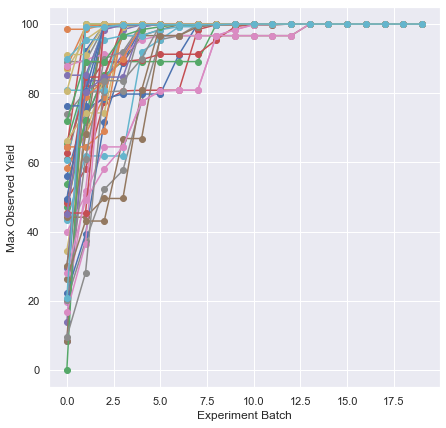

In [22]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (7, 7)

for i in range(len(max_paths)):
    plt.plot(range(len(max_paths[i])), max_paths[i], '-o', label=data['nickname'].values[i])
    
plt.xlabel('Experiment Batch', fontsize=12)
plt.ylabel('Max Observed Yield', fontsize=12)
#plt.legend(loc='lower right', shadow=True)


#plt.savefig('bo-raw_paths.svg', format='svg', dpi=1200, bbox_inches='tight')

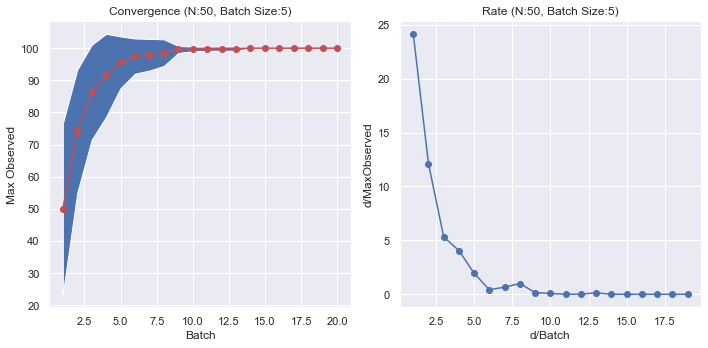

In [14]:
plot_avg_convergence(results, 5, export_path='test_set_results')

In [11]:
from plot_utils import max_observed
import numpy as np

# Human raw data
human_maxs = []
for i in range(len(data)):
    index, maxs_i = max_observed(data[yield_columns].iloc[i].dropna().values, 5)
    human_maxs.append(maxs_i)
    
human_maxs_df = pd.DataFrame(human_maxs)

human_mean = []
for i in range(20):
    values = human_maxs_df.iloc[:,i].dropna()
    human_mean.append(np.mean(values))
    
# Human upper bound
human_maxs_upper = []
for i in range(len(data)):
    index, maxs_i = max_observed(data[yield_columns].iloc[i].fillna(value=100).values, 5)
    human_maxs_upper.append(maxs_i)
    
human_maxs_upper_df = pd.DataFrame(human_maxs_upper)

human_mean_upper = []
for i in range(20):
    values = human_maxs_upper_df.iloc[:,i].dropna()
    human_mean_upper.append(np.mean(values))
    
# Human lower bound
human_maxs_lower = []
for i in range(len(data)):
    index, maxs_i = max_observed(data[yield_columns].iloc[i].fillna(value=0).values, 5)
    human_maxs_lower.append(maxs_i)
    
human_maxs_lower_df = pd.DataFrame(human_maxs_lower)

human_mean_lower = []
for i in range(20):
    values = human_maxs_lower_df.iloc[:,i].dropna()
    human_mean_lower.append(np.mean(values))
    
# BRO max observed values
bro_maxs = []
for i in range(len(results)):
    index, maxs_i = max_observed(results.iloc[i].values, 5)
    bro_maxs.append(maxs_i)
    
bro_maxs_df = pd.DataFrame(bro_maxs)

bro_mean = []
for i in range(20):
    values = bro_maxs_df.iloc[:,i].dropna()
    bro_mean.append(np.mean(values))

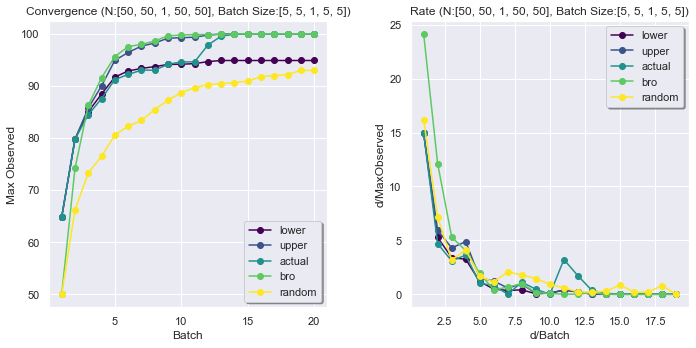

In [12]:
compare_convergence([data.fillna(value=0)[yield_columns].iloc[:,:100].values,
                     data.fillna(value=100)[yield_columns].iloc[:,:100].values,
                     [human_mean],
                     results,
                     random_baseline
                    
                    ], 
                    [5, 5, 1, 5, 5],
                    ['lower', 'upper', 'actual', 'bro', 'random'])

In [13]:
# AB Testing
# Example from: https://www.statsdirect.com/help/default.htm#parametric_methods/unpaired_t.htm

import statsmodels.stats.api as sms

def t_test_summary(X1, X2, sample_vars='equal', print_out=True):
    
    if sample_vars == 'equal':
        usevar = 'pooled'
    else:
        usevar = 'unequal'
        
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    ci = cm.tconfint_diff(usevar=usevar)
    t_value = cm.ttest_ind(usevar=usevar)
    
    if print_out == True:
        print('95% CI:', ci)
        print('DOF:', t_value[2])
        print('t-stat:', t_value[0])
        print('p-value:', t_value[1])
    else:
        return [t_value[2], t_value[0], t_value[1], ci[0], ci[1]]
    
def z_test_summary(X1, X2, sample_vars='equal', print_out=True):
    
    if sample_vars == 'equal':
        usevar = 'pooled'
    else:
        usevar = 'unequal'
        
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    ci = cm.zconfint_diff(usevar=usevar)
    t_value = cm.ztest_ind(usevar=usevar)
    
    if print_out == True:
        print('95% CI:', ci)
        print('z-stat:', t_value[0])
        print('p-value:', t_value[1])
    else:
        return [t_value[0], t_value[1], ci[0], ci[1]]
    
high_protein = np.array([134, 146, 104, 119, 124, 161, 107, 83, 113, 129, 97, 123])
low_protein = np.array([70, 118, 101, 85, 107, 132, 94])

print('t-test w/ equal sample variance assumed:\n')
t_test_summary(high_protein, low_protein)

print('\nt-test w/ unequal sample variance assumed:\n')
t_test_summary(high_protein, low_protein, sample_vars='unequal')


t-test w/ equal sample variance assumed:

95% CI: (-2.1936790647768376, 40.19367906477684)
DOF: 17.0
t-stat: 1.89143639744233
p-value: 0.07573012895667763

t-test w/ unequal sample variance assumed:

95% CI: (-2.4690729418019366, 40.46907294180194)
DOF: 13.08170211326856
t-stat: 1.9107001042454415
p-value: 0.07820704092145603


In [14]:
# T-statistics

# Raw data

i = 10
DATA = human_maxs_df

def path_stats(DATA, steps=range(11)):

    summary = []
    for i in steps:
        human = DATA.iloc[:,i].dropna().values
        bro = bro_maxs_df.iloc[:,i].values
    
        test = t_test_summary(human, bro, sample_vars='unequal', print_out=False)
        summary.append([i] + test)
        
    summary = pd.DataFrame(summary, columns=['Optimization Step', 'DOF', 't-statistic', 'p-value', '95% CI (lower)', '95% CI (upper)'])
    
    return summary

def path_stats_z(DATA, steps=range(11)):

    summary = []
    for i in steps:
        human = DATA.iloc[:,i].dropna().values
        bro = bro_maxs_df.iloc[:,i].values
    
        test = z_test_summary(human, bro, sample_vars='unequal', print_out=False)
        summary.append([i] + test)
        
    summary = pd.DataFrame(summary, columns=['Optimization Step', 'z-statistic', 'p-value', '95% CI (lower)', '95% CI (upper)'])
    
    return summary

In [15]:
print('\nH0: Raw Data | human mean = bro mean | CI for difference (human - bro)\n')
ps1 = path_stats(human_maxs_df, steps=range(20))
ps1


H0: Raw Data | human mean = bro mean | CI for difference (human - bro)



C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\statsmodels\stats\weightstats.py:823: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(d1._var / (d1.nobs-1) + d2._var / (d2.nobs-1))
C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\statsmodels\stats\weightstats.py:847: RuntimeWarning: invalid value encountered in double_scalars
  sem1 = d1._var / (d1.nobs-1)
C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\scipy\stats\_continuous_distns.py:5250: RuntimeWarning: invalid value encountered in greater
  return df > 0
C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: 

Optimization Step        DOF  t-statistic   p-value  95% CI (lower)  \
0                   0  95.067715     2.994461  0.003505        4.998112   
1                   1  91.724019     1.630232  0.106482       -1.228430   
2                   2  92.928723    -0.639638  0.523982       -7.317189   
3                   3  88.365295    -1.671531  0.098155       -8.771690   
4                   4  54.022452    -2.183249  0.033381       -8.476523   
..                ...        ...          ...       ...             ...   
15                 15        NaN          NaN       NaN             NaN   
16                 16        NaN          NaN       NaN             NaN   
17                 17        NaN          NaN       NaN             NaN   
18                 18        NaN          NaN       NaN             NaN   
19                 19        NaN          NaN       NaN             NaN   

    95% CI (upper)  
0        24.661488  
1        12.481230  
2         3.751833  
3         0.756753  
4        -0.361049  
..             ...  
15             NaN  
16             NaN  
17             NaN  
18             NaN  
19             NaN  

[20 rows x 6 columns]

In [16]:
print('\nH0: Lower Bound Data | human mean = bro mean | CI for difference (human - bro)\n')
ps2 = path_stats(human_maxs_lower_df, steps=range(20))
ps2


H0: Lower Bound Data | human mean = bro mean | CI for difference (human - bro)



Optimization Step        DOF  t-statistic   p-value  95% CI (lower)  \
0                   0  95.067715     2.994461  0.003505        4.998112   
1                   1  91.724019     1.630232  0.106482       -1.228430   
2                   2  94.178764    -0.444159  0.657946       -6.624394   
3                   3  89.553441    -1.367395  0.174924       -7.658231   
4                   4  97.999536    -2.414367  0.017618       -7.159500   
..                ...        ...          ...       ...             ...   
15                 15  49.000000    -5.355924  0.000002       -7.053432   
16                 16  49.000000    -5.355924  0.000002       -7.053432   
17                 17  49.000000    -5.355924  0.000002       -7.053432   
18                 18  49.000000    -5.355924  0.000002       -7.053432   
19                 19  49.000000    -5.355924  0.000002       -7.053432   

    95% CI (upper)  
0        24.661488  
1        12.481230  
2         4.202394  
3         1.414231  
4        -0.699700  
..             ...  
15       -3.204568  
16       -3.204568  
17       -3.204568  
18       -3.204568  
19       -3.204568  

[20 rows x 6 columns]

In [17]:
print('\nH0: Upper Bound Data | human mean = bro mean | CI for difference (human - bro)\n')
ps3 = path_stats(human_maxs_upper_df, steps=range(20))
ps3


H0: Upper Bound Data | human mean = bro mean | CI for difference (human - bro)



C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\statsmodels\stats\weightstats.py:850: RuntimeWarning: invalid value encountered in double_scalars
  z1 = (sem1 / semsum)**2 / (d1.nobs - 1)
C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\statsmodels\stats\weightstats.py:851: RuntimeWarning: invalid value encountered in double_scalars
  z2 = (sem2 / semsum)**2 / (d2.nobs - 1)
C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\statsmodels\stats\weightstats.py:617: RuntimeWarning: invalid value encountered in double_scalars
  tstat = (value1 - value2 - diff) / std_diff


Optimization Step        DOF  t-statistic   p-value  95% CI (lower)  \
0                   0  95.067715     2.994461  0.003505        4.998112   
1                   1  91.724019     1.630232  0.106482       -1.228430   
2                   2  95.182651    -0.194098  0.846513       -6.015884   
3                   3  92.540197    -0.661737  0.509784       -6.199285   
4                   4  97.996196    -0.443984  0.658033       -3.935982   
..                ...        ...          ...       ...             ...   
15                 15        NaN          NaN       NaN             NaN   
16                 16        NaN          NaN       NaN             NaN   
17                 17        NaN          NaN       NaN             NaN   
18                 18        NaN          NaN       NaN             NaN   
19                 19        NaN          NaN       NaN             NaN   

    95% CI (upper)  
0        24.661488  
1        12.481230  
2         4.944284  
3         3.100485  
4         2.496782  
..             ...  
15             NaN  
16             NaN  
17             NaN  
18             NaN  
19             NaN  

[20 rows x 6 columns]

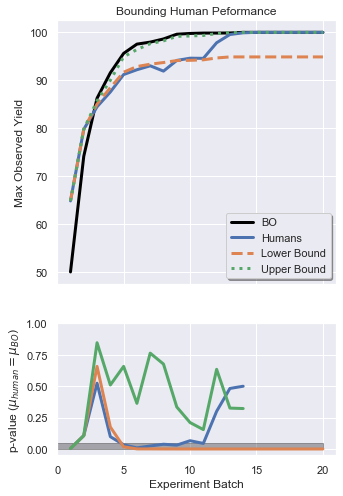

In [34]:
from matplotlib import gridspec


fig = plt.figure(figsize=(5, 8)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.5]) 

# Learning Curves 
index = bro_maxs_df.columns.values + 1

ax0 = plt.subplot(gs[0])
ax0.plot(index, bro_maxs_df.mean(), color='black', linewidth=3, label='BO')
ax0.plot(index, human_maxs_df.mean(), color='C0', linewidth=3, label='Humans')
ax0.plot(index, human_maxs_lower_df.mean(), '--' , color='C1', linewidth=3, alpha=1, label='Lower Bound')
ax0.plot(index, human_maxs_upper_df.mean(), ':', color='C2', linewidth=3, alpha=1, label='Upper Bound')
#ax0.fill_between(index, human_maxs_lower_df.mean(), human_maxs_upper_df.mean(), alpha = 0.2, color='C3')
ax0.set_title('Bounding Human Peformance')
ax0.set_ylabel('Max Observed Yield')
ax0.set_xticklabels([])
ax0.set_xlim(0,21)
ax0.legend(loc='lower right', shadow=True)

ax1 = plt.subplot(gs[1])
ax1.fill_between([0,20], [0.05, 0.05], color='black', alpha=0.3)
ax1.plot(index, ps1['p-value'], linewidth=3)
ax1.plot(index, ps2['p-value'], linewidth=3)
ax1.plot(index, ps3['p-value'], linewidth=3)
ax1.set_xticklabels([0,5,10,15,20])
ax1.set_ylim(-0.05, 1)
ax1.set_ylabel('p-value ($\mu_{human}=\mu_{BO}$)')
ax1.set_xlabel('Experiment Batch')
ax1.set_xlim(0,21)

#plt.savefig('human_vs_bo_performance.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()

In [33]:
human_maxs_df.mean()

0      64.799600
1      79.760000
2      84.461522
3      87.550732
4      91.192414
         ...    
15    100.000000
16    100.000000
17    100.000000
18    100.000000
19    100.000000
Length: 20, dtype: float64

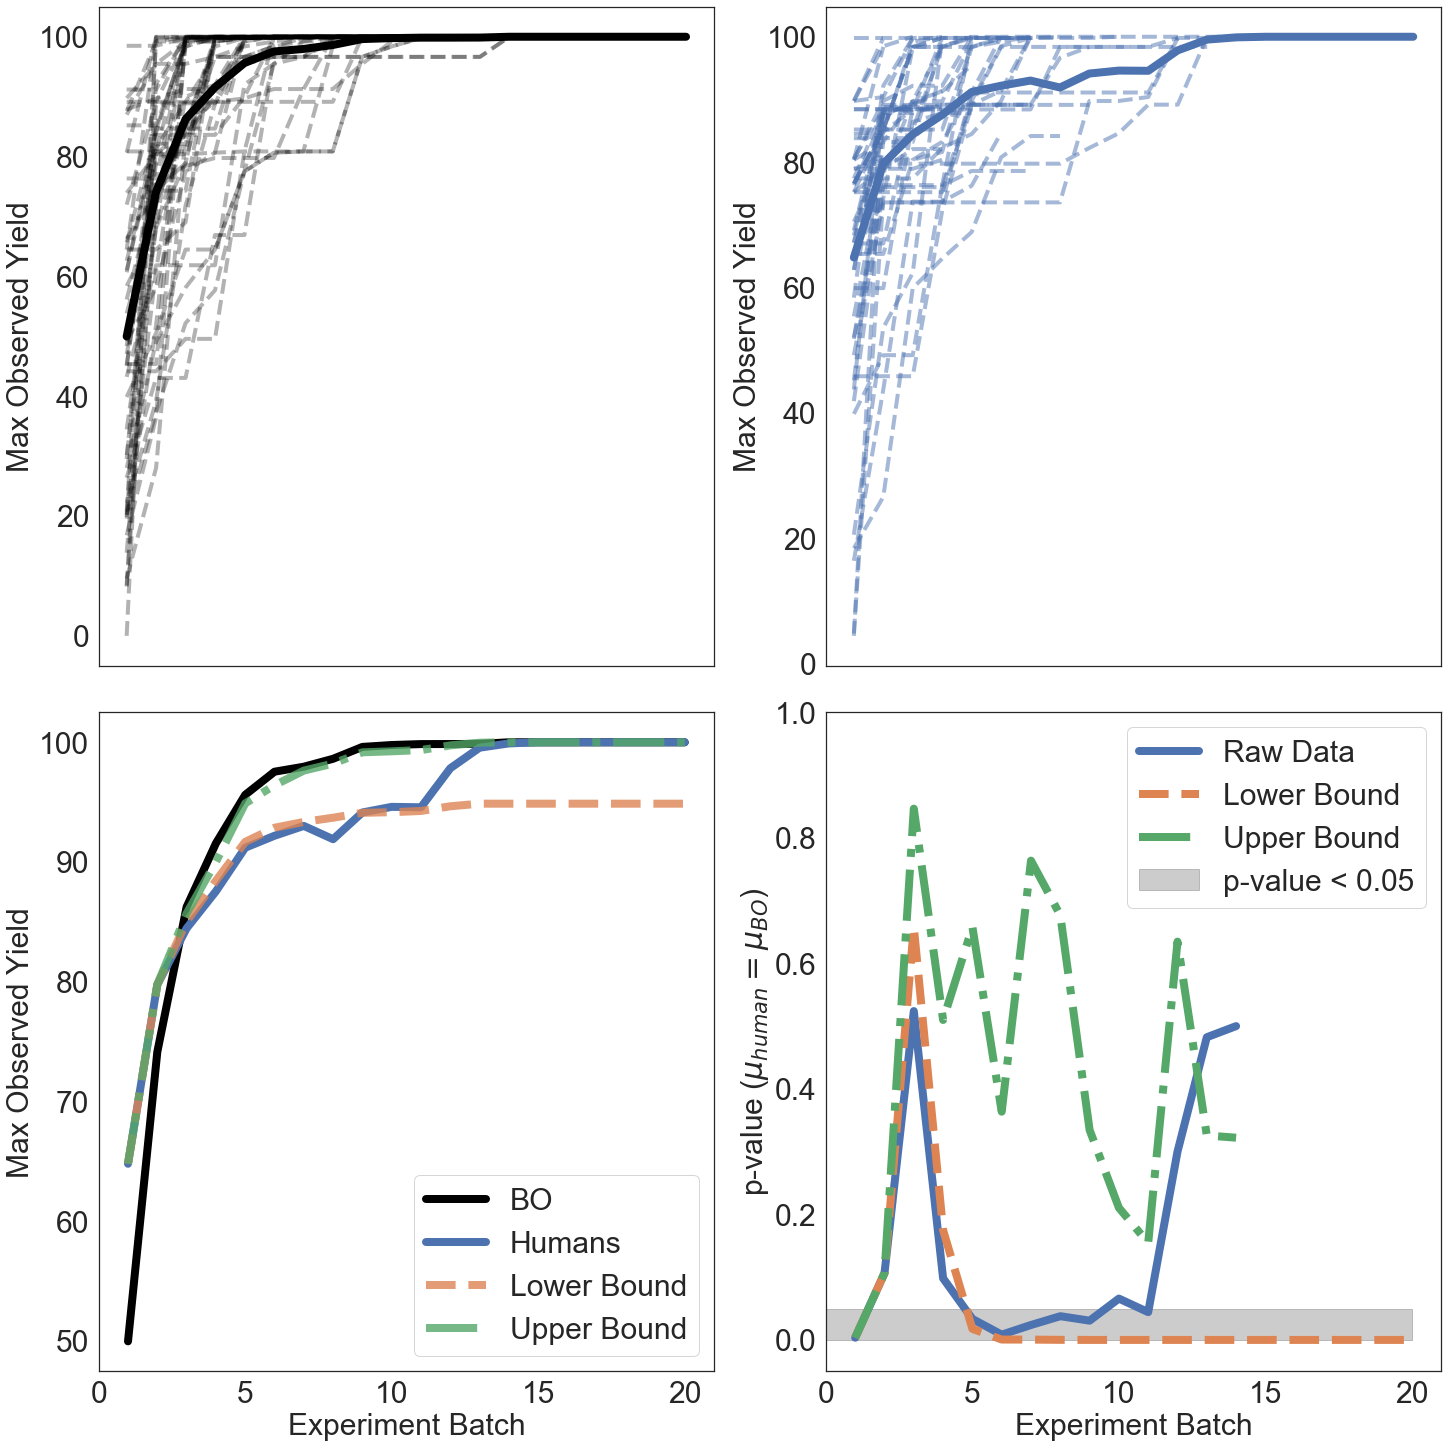

In [70]:
from matplotlib import gridspec

sns.set(style='darkgrid')
sns.set(style='white')

fig , axs = plt.subplots(2,2, figsize=(20, 20), constrained_layout=True)
ax0 = axs[0][0]
ax1 = axs[0][1]
ax2 = axs[1][0]
ax3 = axs[1][1]

index = bro_maxs_df.columns.values + 1
font_size = 30

# BRO Raw Paths
for path in bro_maxs:
    ax0.plot(index, path, '--', color='black', linewidth=4, alpha=0.3)
ax0.plot(index, bro_maxs_df.mean(), color='black', linewidth=8)
ax0.set_xticks([])
ax0.set_ylabel('Max Observed Yield', fontsize=font_size)

# Human Raw Paths
for path in human_maxs:
    ax1.plot(range(1, len(path)+1), path, '--', color='C0', linewidth=4, alpha=0.5)
ax1.plot(index, human_maxs_df.mean(), color='C0', linewidth=8)
ax1.set_xticks([])
ax1.set_ylabel('Max Observed Yield', fontsize=font_size)

# Comparision curves
ax2.plot(index, bro_maxs_df.mean(), color='black', linewidth=8, label='BO')
ax2.plot(index, human_maxs_df.mean(), color='C0', linewidth=8, label='Humans')
ax2.plot(index, human_maxs_lower_df.mean(), '--' , color='C1', linewidth=8, alpha=0.8, label='Lower Bound')
ax2.plot(index, human_maxs_upper_df.mean(), '-.', color='C2', linewidth=8, alpha=0.8, label='Upper Bound')
ax2.set_ylabel('Max Observed Yield', fontsize=font_size)
ax2.set_xlim(0,21)
ax2.legend(loc='lower right', fontsize=font_size)
ax2.set_xlabel('Experiment Batch', fontsize=font_size)

# Hypothesis test
ax3.fill_between([0,20], [0.05, 0.05], color='black', alpha=0.2, label='p-value < 0.05')
ax3.plot(index, ps1['p-value'], linewidth=8, label='Raw Data')
ax3.plot(index, ps2['p-value'], '--', linewidth=8, label='Lower Bound')
ax3.plot(index, ps3['p-value'], '-.', linewidth=8, label='Upper Bound')
ax3.set_ylim(-0.05, 1)
ax3.set_ylabel('p-value ($\mu_{human}=\mu_{BO}$)', fontsize=font_size)
ax3.set_xlabel('Experiment Batch', fontsize=font_size)
ax3.set_xlim(0,21)
ax3.legend(loc='upper right', fontsize=font_size)

# All formatting
for ax in (ax0, ax1, ax2, ax3):
    ax.tick_params(axis="x", labelsize=font_size)
    ax.tick_params(axis="y", labelsize=font_size)

plt.savefig('human_vs_bo_performance-paper.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()